In [22]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [23]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

TRAIN = ['../data/train_image_data_0.parquet',
         '../data/train_image_data_1.parquet',
         '../data/train_image_data_2.parquet',
         '../data/train_image_data_3.parquet']

OUT_TRAIN = '../train_images/'

TEST = ['../data/test_image_data_0.parquet',
         '../data/test_image_data_1.parquet',
         '../data/test_image_data_2.parquet',
         '../data/test_image_data_3.parquet']

OUT_TEST = '../test_images/'

In [25]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

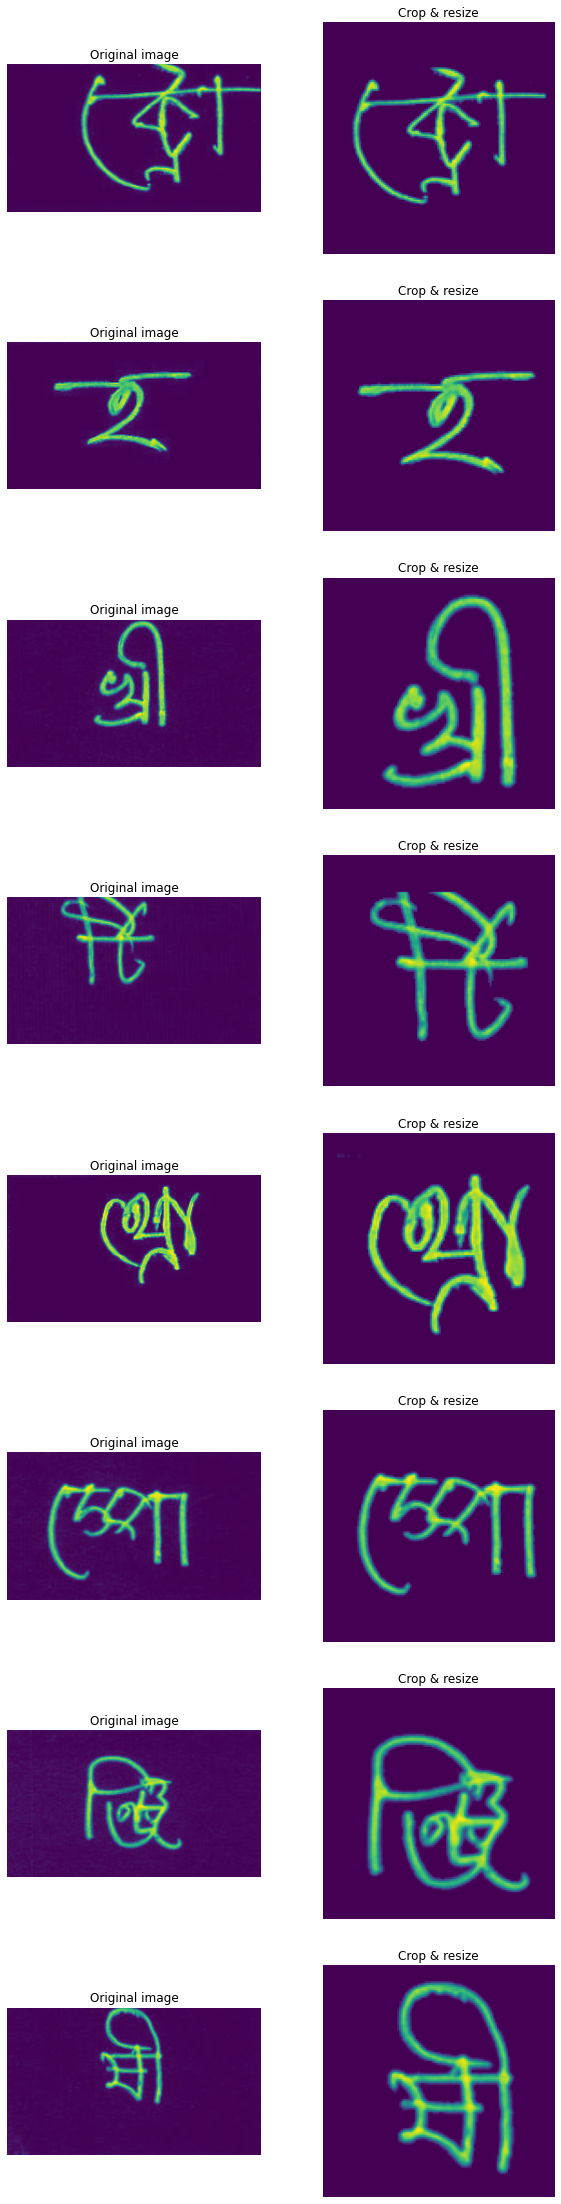

In [26]:
df = pd.read_parquet(TRAIN[0])
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [27]:
def generate_images(paths_list, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for fname in paths_list:
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)

            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            with open(output_dir + name + '.png', 'wb+') as f:
                f.write(img.tobytes())

In [28]:
generate_images(TRAIN, OUT_TRAIN)
generate_images(TEST, OUT_TEST)

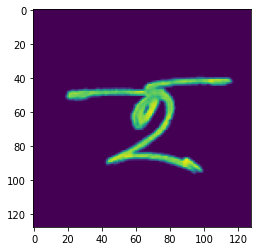

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_name = OUT_TRAIN + "Train_1.png"

img=mpimg.imread(img_name)
imgplot = plt.imshow(img)
plt.show()